# Group simulator tests and comparison with Heises original version
In this script we compare our version of group simulator to Heise's original version that was published alongside
his article (Heise, D. R. (2013). Modeling Interactions in Small Groups. Social Psychology Quarterly, 76(1), 52–72. doi: 10.1177/0190272512467654) and to the empirical data that he also compared his results to taken from (Strodtbeck, Fred L.Mann, Richard D.,1956, Sex Role Differentiation in Jury Deliberations, Sociometry).

When porting the ACT-core from netlogo to python we fixed a bug in the object selection that was present in Heise's version. That is the reason why results differ slightly. We checked that without fixing the bug, we get the exact same results. 

We also compare the effects of different object-selection-criterea and introduce a new object-selection-criterion that we name maximum-deflection-reduction and which adheres (like the name suggests) most closely to the ACT-principle in the sense that it selects the object in such a way as to minimize deflection in the group (not just the event).

In [1]:
from ACTING_base import *
import itertools
import pickle
import networkx as nx
from nxpd import draw
from IPython.display import display
import numpy as np
import seaborn as sns
from mesa.batchrunner import BatchRunner
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# data taken from Strodtbeck, Fred L.Mann, Richard D.,1956, Sex Role Differentiation in Jury Deliberations,
# Sociometry
male_inactive = np.array([1.14, 1.75, 10.50, 3.50, 25.44, 41.59, 4.85, 1.08, 0.00, 6.46, 1.82, 1.88])
male_inactive_base = 1486
male_active = np.array([1.03, 1.50, 8.26, 3.54, 19.42, 48.49, 5.09, 2.65, 0.08, 4.99, 2.61, 2.36])
male_active_base = 12413
female_inactive = np.array([1.39, 8.49, 16.98, 2.31, 22.07, 35.96, 6.33, 0.77, 0.00, 3.70, 1.54, 0.46])
female_inactive_base = 648
female_active = np.array([1.45, 2.91, 20.59, 1.52, 18.07, 34.95, 6.76, 1.26, 0.03, 9.31, 2.36, 0.77])
female_active_base = 3093

male_total_percentages = (male_inactive * male_inactive_base + male_active * male_active_base)/(male_inactive_base + male_active_base)/100
female_total_percentages = (female_inactive * female_inactive_base + female_active * female_active_base)/(female_inactive_base + female_active_base)/100
gender_diff_percentages = male_total_percentages - female_total_percentages

#Taken from Heise article
male_epa = [0.8, 1.6, -0.5]
female_epa = [1.2, 0.7, 0.0]

# Emperical data for IPA category percentages of all actions
empirical = np.array([1.2,3.0,17.9,4.0,26.1,38.3,4.6,1.9,0.2,2.0,0.6,0.2])/100

#### Some helper functions for preprocessing and visualization etc.

In [3]:
#helper class, because variable parameters passed to mesas Batchrunner have to provide hash
class Hashabledict(dict):
    def __hash__(self):
        return hash(np.random.random())
    
def agent_data_collector(model):
    return model.datacollector.get_agent_vars_dataframe()

def model_data_collector(model):
    return model.datacollector.get_model_vars_dataframe()

def create_jury(males=8, females=4):
    agentlist = []
    # male jurors
    for x in range(males):
        agentlist.append(Hashabledict({'epa' : random_epa(male_epa, 1.0), 'initial_tension': 1.0}))

    # female jurors
    for x in range(females):
        agentlist.append(Hashabledict({'epa' : random_epa(female_epa, 1.0), 'initial_tension': 1.0}))
    return agentlist

def all_agents_means(df):
    agentdf = df["agent data"]
    zwi = pd.concat([f for f in agentdf])
    by_row_index = zwi.groupby("Step")
    df_means = by_row_index.mean()
    return df_means

epa_colors=["#cb9f00", "#058c7d", "#78325f"]
n_colors = ["#077043",  "#6b7b38", "#959a23", "#b35b1d", "#a13327", "#4e2963", "#2A3E4D","#C58648"]

bins12=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

## Minimum event tension 
This corresponds to Heise's original simulations only that we fixed a bug in the object selection.
Parameters are chosen to be the same as in Heise's simulations

In [4]:
np.random.seed(456) #set a seed for reproduceability
juries = [tuple(create_jury(8,4)) for _ in range(500)]

fixed_params = {
                "data_model": "us_unisex",
                "actor_choice" : "max self-tension",
                "action_on_group" : True,
                "reciprocity_rate": 0.8,
                "group_action_rate": 0.4
               }
variable_params = {"agents": juries
                  }


batch_run = BatchRunner(GroupModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=1,
                        max_steps=1000,
                        model_reporters={"model data": model_data_collector, "agent data": agent_data_collector}
                       )
                      
batch_run.run_all()
min_event_tension = batch_run.get_model_vars_dataframe()

500it [10:10,  1.22s/it]


#### Distribution Bales categories

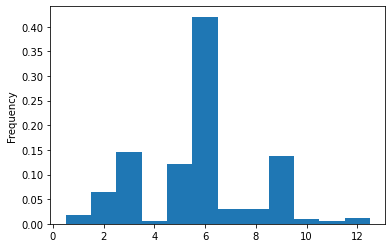

In [5]:
mievte = pd.concat(list(min_event_tension["model data"]))
mievte["bales_category"].plot.hist(density=True, bins=bins12)

In [6]:
mievte_hist = np.histogram(mievte ["bales_category"],density=True, bins=bins12)[0]
print("Correlation between empirical  and and simulation settings:  min. event tension object selection")
np.corrcoef(empirical, mievte_hist)

Correlation between empirical  and and simulation settings:  min. event tension object selection


array([[1.        , 0.86680503],
       [0.86680503, 1.        ]])

#### Gender differences

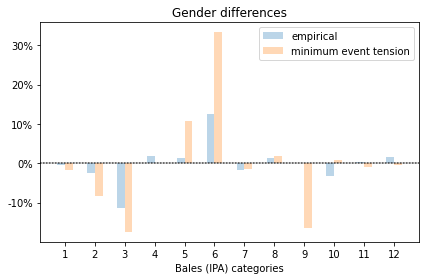

In [7]:
male_bales=[]
for i, row in min_event_tension["model data"].iteritems():
    male_bales += list(row[row["actor"]<8]["bales_category"].values)
female_bales=[]
for i, row in min_event_tension["model data"].iteritems():
    female_bales += list(row[row["actor"]>=8]["bales_category"].values)

male_bales_hist = np.histogram(male_bales,density=True, bins=bins12)[0]
female_bales_hist = np.histogram(female_bales, density=True, bins=bins12)[0]
mievte_gender_diff_percentages = male_bales_hist - female_bales_hist

labels = list(range(1,13,1))
x = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gender_diff_percentages, 2*width,alpha=0.3, label='empirical')
rects2= ax.bar(x + width, mievte_gender_diff_percentages, 2*width,alpha=0.3, label='minimum event tension')
ax.axhline( y=0, xmin=0, xmax=1, color="black", dashes=[0.5, 0.5], alpha=1)
ax.set_xlabel('Bales (IPA) categories')
ax.set_title("Gender differences")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [8]:
print("Gender differences: correlation")
np.corrcoef(gender_diff_percentages,mievte_gender_diff_percentages)

Gender differences: correlation


array([[1.        , 0.84557578],
       [0.84557578, 1.        ]])

## Discrete minimum event tension

In [9]:
np.random.seed(123)
juries = [tuple(create_jury(8,4)) for _ in range(500)]

fixed_params = {
                "data_model": "us_unisex",
                "actor_choice" : "max self-tension",
                "action_on_group" : True,
                "reciprocity_rate": 0.8,
                "group_action_rate": 0.4,
                "discrete_actions": IPA_EPAs_1978
               }
variable_params = {"agents": juries
                  }


batch_run = BatchRunner(GroupModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=1,
                        max_steps=1000,
                        model_reporters={"model data": model_data_collector, "agent data": agent_data_collector}
                       )
                      
batch_run.run_all()
discrete_min_event_tension = batch_run.get_model_vars_dataframe()

500it [23:54,  2.87s/it]


#### Distribution Bales categories

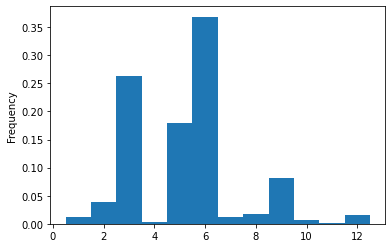

In [10]:
dimievte = pd.concat(list(discrete_min_event_tension["model data"]))
dimievte ["bales_category"].plot.hist(density=True, bins=bins12)

In [11]:
print("Correlation between empirical and simulation settings: discrete behaviors, min. event tension object selection")
dimievte_hist = np.histogram(dimievte ["bales_category"],density=True, bins=bins12)[0]
np.corrcoef(empirical, dimievte_hist)

Correlation between empirical and simulation settings: discrete behaviors, min. event tension object selection


array([[1.       , 0.9301563],
       [0.9301563, 1.       ]])

#### Gender differences

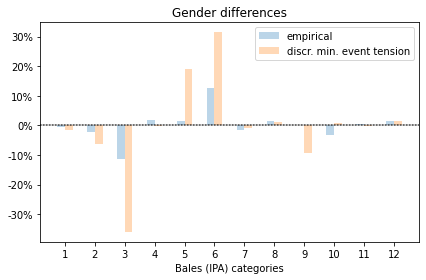

In [12]:
male_bales=[]
for i, row in discrete_min_event_tension["model data"].iteritems():
    male_bales += list(row[row["actor"]<8]["bales_category"].values)
female_bales=[]
for i, row in discrete_min_event_tension["model data"].iteritems():
    female_bales += list(row[row["actor"]>=8]["bales_category"].values)

male_bales_hist = np.histogram(male_bales,density=True, bins=bins12)[0]
female_bales_hist = np.histogram(female_bales, density=True, bins=bins12)[0]
dimievte_gender_diff_percentages = male_bales_hist - female_bales_hist

# the label locations
labels = list(range(1,13,1))
x = np.arange(len(labels)) 
width = 0.13  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gender_diff_percentages, 2*width,alpha=0.3, label='empirical')
rects2= ax.bar(x + width, dimievte_gender_diff_percentages, 2*width,alpha=0.3, label='discr. min. event tension')
ax.axhline( y=0, xmin=0, xmax=1, color="black", dashes=[0.5, 0.5], alpha=1)
ax.set_xlabel('Bales (IPA) categories')
ax.set_title('Gender differences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter(1))
np.corrcoef(gender_diff_percentages, dimievte_gender_diff_percentages)

plt.show()

In [13]:
print("Gender differences: correlation")
np.corrcoef(gender_diff_percentages, dimievte_gender_diff_percentages)

Gender differences: correlation


array([[1.        , 0.90411097],
       [0.90411097, 1.        ]])

## Maximum deflection reduction

In [14]:
np.random.seed(456)

fixed_params = {
                "data_model": "us_unisex",
                "actor_choice" : "max self-tension",
                "object_choice": "max deflection-reduction",
                "action_on_group" : True,
                "reciprocity_rate": 0.8,
                "group_action_rate": 0.4
               }
variable_params = {"agents": juries
                  }


batch_run = BatchRunner(GroupModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=1,
                        max_steps=1000,
                        model_reporters={"model data": model_data_collector, "agent data": agent_data_collector}
                       )
                      
batch_run.run_all()
max_deflection_reduction = batch_run.get_model_vars_dataframe()

500it [11:38,  1.40s/it]


#### Distribution Bales categories

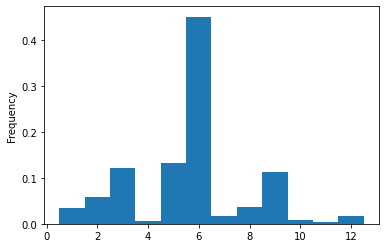

In [15]:
madere = pd.concat(list(max_deflection_reduction["model data"]))
madere["bales_category"].plot.hist(density=True, bins=bins12)

In [16]:
print("Correlation between empirical data and simulation settings: maximum deflection reduction object selection")
madere_hist = np.histogram(madere["bales_category"],density=True, bins=bins12)[0]
np.corrcoef(empirical, madere_hist)

Correlation between empirical data and simulation settings: maximum deflection reduction object selection


array([[1.        , 0.88135166],
       [0.88135166, 1.        ]])

#### Gender differences

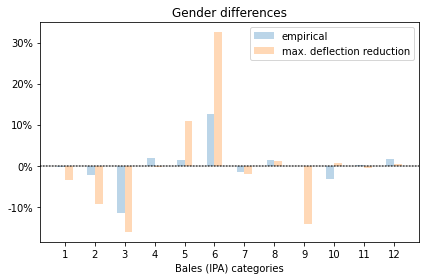

In [17]:
male_bales=[]
for i, row in max_deflection_reduction["model data"].iteritems():
    male_bales += list(row[row["actor"]<8]["bales_category"].values)
female_bales=[]
for i, row in max_deflection_reduction["model data"].iteritems():
    female_bales += list(row[row["actor"]>=8]["bales_category"].values)

male_bales_hist = np.histogram(male_bales,density=True, bins=bins12)[0]
female_bales_hist = np.histogram(female_bales, density=True, bins=bins12)[0]
madere_gender_diff_percentages = male_bales_hist - female_bales_hist

labels = list(range(1,13,1))
x = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gender_diff_percentages, 2*width,alpha=0.3, label='empirical')
rects2= ax.bar(x + width, madere_gender_diff_percentages, 2*width,alpha=0.3, label='max. deflection reduction')
ax.axhline( y=0, xmin=0, xmax=1, color="black", dashes=[0.5, 0.5], alpha=1)
ax.set_title('Gender differences')
ax.set_xlabel('Bales (IPA) categories')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [18]:
print("Gender differences: correlation")
np.corrcoef(gender_diff_percentages, madere_gender_diff_percentages)

Gender differences: correlation


array([[1.        , 0.85207239],
       [0.85207239, 1.        ]])

## Random

In [19]:
fixed_params = {
                "data_model": "us_unisex",
                "actor_choice" : "max self-tension",
                "object_choice": "random",
                "action_on_group" : True,
                "reciprocity_rate": 0.8,
                "group_action_rate": 0.4
               }
variable_params = {"agents": juries
                  }


batch_run = BatchRunner(GroupModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=1,
                        max_steps=1000,
                        model_reporters={"model data": model_data_collector, "agent data": agent_data_collector}
                       )
                      
batch_run.run_all()
random = batch_run.get_model_vars_dataframe()

500it [05:08,  1.62it/s]


#### Distribution Bales categories

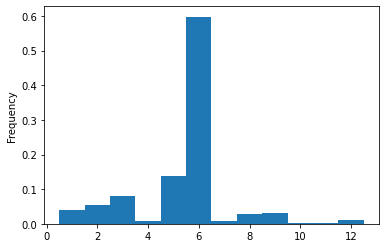

In [20]:
ran = pd.concat(list(random["model data"]))
ran["bales_category"].plot.hist(density=True, bins=bins12)

In [21]:
print("Correlation between empirical data and simulation settings: random object selection")
ran_hist = np.histogram(ran["bales_category"],density=True, bins=bins12)[0]
np.corrcoef(empirical, ran_hist)

Correlation between empirical data and simulation settings: random object selection


array([[1.        , 0.87761764],
       [0.87761764, 1.        ]])

#### Gender differences

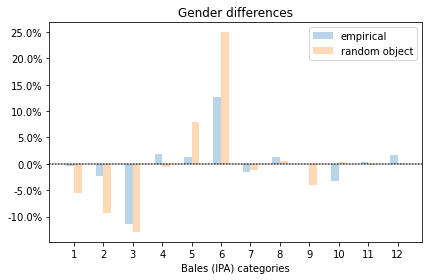

In [22]:
male_bales=[]
for i, row in random["model data"].iteritems():
    male_bales += list(row[row["actor"]<8]["bales_category"].values)
female_bales=[]
for i, row in random["model data"].iteritems():
    female_bales += list(row[row["actor"]>=8]["bales_category"].values)

bins12=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]
male_bales_hist = np.histogram(male_bales,density=True, bins=bins12)[0]
female_bales_hist = np.histogram(female_bales, density=True, bins=bins12)[0]
random_gender_diff_percentages = male_bales_hist - female_bales_hist

labels = list(range(1,13,1))
x = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gender_diff_percentages, 2*width,alpha=0.3, label='empirical')
rects2= ax.bar(x + width, random_gender_diff_percentages, 2*width,alpha=0.3, label='random object')
ax.axhline( y=0, xmin=0, xmax=1, color="black", dashes=[0.5, 0.5], alpha=1)

ax.set_xlabel('Bales (IPA) categories')
ax.set_title('Gender differences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [23]:
print("Gender differences: correlation")
np.corrcoef(gender_diff_percentages, random_gender_diff_percentages)

Gender differences: correlation


array([[1.        , 0.88660556],
       [0.88660556, 1.        ]])

## discrete max deflection reduction

In [24]:
fixed_params = {
                "data_model": "us_unisex",
                "actor_choice" : "max self-tension",
                "object_choice": "max deflection-reduction",
                "action_on_group" : True,
                "reciprocity_rate": 0.8,
                "group_action_rate": 0.4,
                "discrete_actions": IPA_EPAs_1978
               }
variable_params = {"agents": juries
                  }


batch_run = BatchRunner(GroupModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=1,
                        max_steps=1000,
                        model_reporters={"model data": model_data_collector, "agent data": agent_data_collector}
                       )
                      
batch_run.run_all()
discrete_max_deflection_reduction = batch_run.get_model_vars_dataframe()


500it [25:38,  3.08s/it]


#### Distribution Bales categories

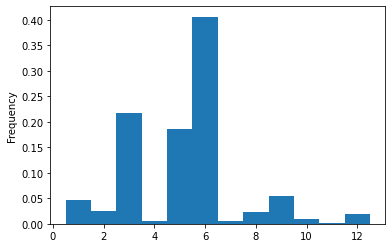

In [25]:
dimadere = pd.concat(list(discrete_max_deflection_reduction["model data"]))
dimadere["bales_category"].plot.hist(density=True, bins=bins12)

In [26]:
dimadere_hist = np.histogram(dimadere["bales_category"],density=True, bins=bins12)[0]
print("Correlation between empirical data and simulation settings: discrete behaviors, maximum deflection reduction object selection")
np.corrcoef(empirical, dimadere_hist)

Correlation between empirical data and simulation settings: discrete behaviors, maximum deflection reduction object selection


array([[1.        , 0.95590354],
       [0.95590354, 1.        ]])

#### Gender differences

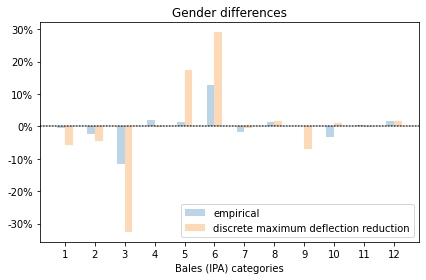

In [27]:
male_bales=[]
for i, row in discrete_max_deflection_reduction["model data"].iteritems():
    male_bales += list(row[row["actor"]<8]["bales_category"].values)
female_bales=[]
for i, row in discrete_max_deflection_reduction["model data"].iteritems():
    female_bales += list(row[row["actor"]>=8]["bales_category"].values)


male_bales_hist = np.histogram(male_bales,density=True, bins=bins12)[0]
female_bales_hist = np.histogram(female_bales, density=True, bins=bins12)[0]
dimadere_gender_diff_percentages = male_bales_hist - female_bales_hist

labels = list(range(1,13,1))
x = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gender_diff_percentages, 2*width,alpha=0.3, label='empirical')
rects2= ax.bar(x + width, dimadere_gender_diff_percentages, 2*width,alpha=0.3, label='discrete maximum deflection reduction')
ax.axhline( y=0, xmin=0, xmax=1, color="black", dashes=[0.5, 0.5], alpha=1)
ax.set_xlabel('Bales (IPA) categories')
ax.set_title('Gender differences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [28]:
print("Gender differences: correlation")
np.corrcoef(gender_diff_percentages, dimadere_gender_diff_percentages)


Gender differences: correlation


array([[1.        , 0.90466981],
       [0.90466981, 1.        ]])

## Discrete random 

In [29]:
fixed_params = {
                "data_model": "us_unisex",
                "actor_choice" : "max self-tension",
                "object_choice": "random",
                "action_on_group" : True,
                "reciprocity_rate": 0.8,
                "group_action_rate": 0.4,
                "discrete_actions": IPA_EPAs_1978
               }
variable_params = {"agents": juries
                  }


batch_run = BatchRunner(GroupModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=1,
                        max_steps=1000,
                        model_reporters={"model data": model_data_collector, "agent data": agent_data_collector}
                       )
                      
batch_run.run_all()
discrete_random  = batch_run.get_model_vars_dataframe()

500it [09:51,  1.18s/it]


#### Distribution Bales categories

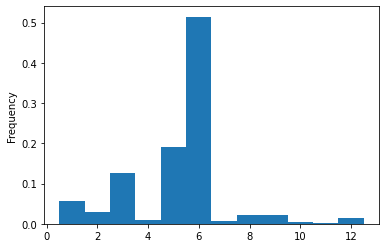

In [30]:
diran = pd.concat(list(discrete_random["model data"]))
diran["bales_category"].plot.hist(density=True, bins=bins12)

In [31]:
diran_hist = np.histogram(diran["bales_category"],density=True, bins=bins12)[0]
print("Correlation between empirical data and simulation settings: discrete behaviors, random object selection")
np.corrcoef(empirical, mievte_hist)

Correlation between empirical data and simulation settings: discrete behaviors, random object selection


array([[1.        , 0.86680503],
       [0.86680503, 1.        ]])

#### Gender differences

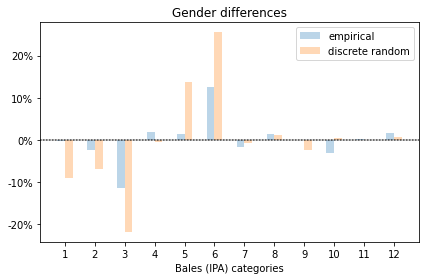

In [32]:
male_bales=[]
for i, row in discrete_random["model data"].iteritems():
    male_bales += list(row[row["actor"]<8]["bales_category"].values)
female_bales=[]
for i, row in discrete_random["model data"].iteritems():
    female_bales += list(row[row["actor"]>=8]["bales_category"].values)

male_bales_hist = np.histogram(male_bales,density=True, bins=bins12)[0]
female_bales_hist = np.histogram(female_bales, density=True, bins=bins12)[0]
diran_gender_diff_percentages = male_bales_hist - female_bales_hist

labels = list(range(1,13,1))
x = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gender_diff_percentages, 2*width,alpha=0.3, label='empirical')
rects2= ax.bar(x + width, diran_gender_diff_percentages, 2*width,alpha=0.3, label='discrete random')
ax.axhline( y=0, xmin=0, xmax=1, color="black", dashes=[0.5, 0.5], alpha=1)
ax.set_xlabel('Bales (IPA) categories')
ax.set_title('Gender differences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [33]:
print("Gender differences: correlation")
np.corrcoef(gender_diff_percentages, diran_gender_diff_percentages)

Gender differences: correlation


array([[1.        , 0.89632582],
       [0.89632582, 1.        ]])

# Summary 
### Comparison IPA category percentages, empirical data and  different simulation settings

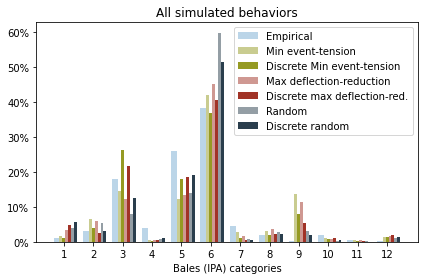

In [34]:
labels = list(range(1,13,1))
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x -2.5*width, empirical, 2*width,alpha=0.3, label='Empirical')
ax.bar(x - width, mievte_hist, width, color = n_colors[2], alpha=0.5, label='Min event-tension')
ax.bar(x , dimievte_hist, width, color = n_colors[2], label='Discrete Min event-tension')
ax.bar(x + width, madere_hist, width,color = n_colors[4],  alpha=0.5, label='Max deflection-reduction')
ax.bar(x + 2*width, dimadere_hist, width,color = n_colors[4],label='Discrete max deflection-red.')
ax.bar(x + 3*width, ran_hist, width, color = n_colors[6],  alpha=0.5, label='Random')
ax.bar(x + 4*width, diran_hist, width,color = n_colors[6],label='Discrete random')


# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_xlabel('Bales (IPA) categories')
ax.set_title('All simulated behaviors')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

fig.tight_layout()

plt.show()

### Correlations between empirical data and  different simulation settings for IPA-distributions

In [35]:
print("CORRELATIONS:")
print("min event-tension:")
print(np.corrcoef(empirical, mievte_hist))
print("discrete min event-tension:")
print(np.corrcoef(empirical, dimievte_hist))
print("max deflection reduction:")
print(np.corrcoef(empirical, madere_hist))
print("discrete max deflection reduction:")
print(np.corrcoef(empirical, dimadere_hist))
print("random object selection:")
print(np.corrcoef(empirical, ran_hist))
print("discrete random object selection:")
print(np.corrcoef(empirical, diran_hist))

CORRELATIONS:
min event-tension:
[[1.         0.86680503]
 [0.86680503 1.        ]]
discrete min event-tension:
[[1.        0.9301563]
 [0.9301563 1.       ]]
max deflection reduction:
[[1.         0.88135166]
 [0.88135166 1.        ]]
discrete max deflection reduction:
[[1.         0.95590354]
 [0.95590354 1.        ]]
random object selection:
[[1.         0.87761764]
 [0.87761764 1.        ]]
discrete random object selection:
[[1.         0.94031249]
 [0.94031249 1.        ]]


### Average deflection of agents 

In [36]:
def_min_event_tension = all_agents_means(min_event_tension)["Deflection"]
def_discrete_min_event_tension = all_agents_means(discrete_min_event_tension)["Deflection"]
def_max_deflection_reduction = all_agents_means(max_deflection_reduction)["Deflection"]
def_discrete_max_deflection_reduction = all_agents_means(discrete_max_deflection_reduction)["Deflection"]
def_random = all_agents_means(random)["Deflection"]
def_discrete_random = all_agents_means(discrete_random)["Deflection"]

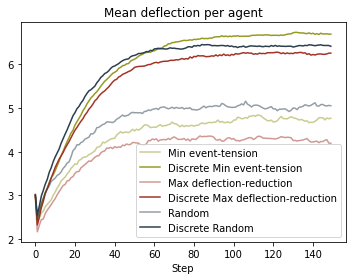

In [37]:
fig, ax = plt.subplots(figsize=(5,4))

def_min_event_tension[0:150].plot(color=n_colors[2], alpha=0.5, label='Min event-tension', ax=ax)
def_discrete_min_event_tension[0:150].plot(color=n_colors[2], label='Discrete Min event-tension', ax=ax)

def_max_deflection_reduction[0:150].plot(color=n_colors[4], alpha=0.5, label='Max deflection-reduction', ax=ax)
def_discrete_max_deflection_reduction[0:150].plot(color=n_colors[4], label='Discrete Max deflection-reduction', ax=ax)

def_random[0:150].plot(color=n_colors[6], alpha=0.5, label='Random', ax=ax)
def_discrete_random[0:150].plot(color=n_colors[6],  label='Discrete Random', ax=ax)

ax.set_title('Mean deflection per agent')
ax.legend()


fig.tight_layout()

plt.show()

### Gender differences in  IPA category percentages

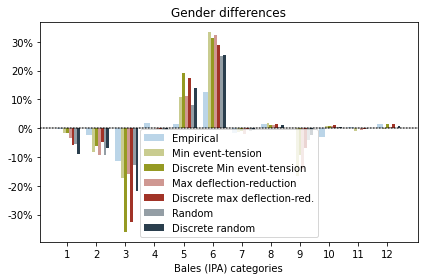

In [38]:
labels = list(range(1,13,1))
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x -2.5*width, gender_diff_percentages, 2*width,alpha=0.3, label='Empirical')
ax.bar(x - width, mievte_gender_diff_percentages, width, color = n_colors[2], alpha=0.5, label='Min event-tension')
ax.bar(x , dimievte_gender_diff_percentages, width, color = n_colors[2], label='Discrete Min event-tension')
ax.bar(x + width, madere_gender_diff_percentages, width,color = n_colors[4],  alpha=0.5, label='Max deflection-reduction')
ax.bar(x + 2*width, dimadere_gender_diff_percentages, width,color = n_colors[4],label='Discrete max deflection-red.')
ax.bar(x + 3*width, random_gender_diff_percentages, width,color = n_colors[6],  alpha=0.5, label='Random')
ax.bar(x + 4*width, diran_gender_diff_percentages, width,color = n_colors[6],label='Discrete random')

ax.set_xlabel('Bales (IPA) categories')
ax.set_title('Gender differences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline( y=0, xmin=0, xmax=1, color="black", dashes=[0.5, 0.5], alpha=1)
vals = ax.get_yticks()
ax.legend()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
fig.tight_layout()
plt.show()

### Gender differences: Correlations between empirical data and  different simulation settings for IPA-distributions

In [39]:
print("CORRELATIONS:")
print("min event-tension:")
print(np.corrcoef(gender_diff_percentages, mievte_gender_diff_percentages))
print("discrete min event-tension:")
print(np.corrcoef(gender_diff_percentages, dimievte_gender_diff_percentages))
print("max deflection reduction:")
print(np.corrcoef(gender_diff_percentages, madere_gender_diff_percentages))
print("discrete max deflection reduction:")
print(np.corrcoef(gender_diff_percentages, dimadere_gender_diff_percentages))
print("random object selection:")
print(np.corrcoef(gender_diff_percentages, random_gender_diff_percentages))
print("discrete random object selection:")
print(np.corrcoef(gender_diff_percentages, diran_gender_diff_percentages))

CORRELATIONS:
min event-tension:
[[1.         0.84557578]
 [0.84557578 1.        ]]
discrete min event-tension:
[[1.         0.90411097]
 [0.90411097 1.        ]]
max deflection reduction:
[[1.         0.85207239]
 [0.85207239 1.        ]]
discrete max deflection reduction:
[[1.         0.90466981]
 [0.90466981 1.        ]]
random object selection:
[[1.         0.88660556]
 [0.88660556 1.        ]]
discrete random object selection:
[[1.         0.89632582]
 [0.89632582 1.        ]]
